In [1]:
# !pip install leidenalg

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
from statistics import median
import gzip
import scipy.io
import scanpy as sc

# Part 1. Load and filter data

In [3]:
filename = "GSE89567_IDH_A_processed_data.txt.gz"
raw = pd.read_csv(filename, compression='gzip', sep='\t', index_col=0)
raw.index = [gene.strip("'") for gene in raw.index]
raw

,MGH42_P7_A01,MGH42_P7_A02,MGH42_P7_A03,MGH42_P7_A04,MGH42_P7_A05,MGH42_P7_A07,MGH42_P7_A09,MGH42_P7_A11,MGH42_P7_A12,MGH42_P7_B02,...,MGH107neg_P2_E06,MGH107pos_P2_B03,MGH107neg_P1_F03,MGH107neg_P1_G06,MGH107neg_P2_H03,MGH107neg_P2_C05,MGH107pos_P2_D07,MGH107neg_P1_E01,MGH107pos_P2_G09,MGH107neg_P1_D06
A1BG,1.19280,0.000000,0.00000,0.00000,0.00000,0.66903,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.4772,0.00000,0.0000
A1BG-AS1,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.83996,0.00000,0.0000,0.00000,0.0000
A1CF,0.00000,0.094912,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.0000
A2M,7.04390,7.609500,0.77062,7.61460,0.00000,0.00000,0.27501,8.16240,6.56550,6.96580,...,0.00000,8.60460,0.00000,0.00000,0.00000,0.00000,9.52810,0.0000,6.89990,0.0000
A2M-AS1,0.00000,0.000000,0.00000,0.00000,2.03390,2.39420,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.00000,0.370720,0.47508,0.15056,0.47508,0.26063,0.15704,0.26664,0.34483,0.24610,...,0.25580,0.13225,0.50080,0.31383,0.50691,0.17505,0.13225,0.9381,0.47301,0.0000
ZYG11B,0.27143,0.444670,3.13260,1.48650,4.03830,2.00580,2.73880,0.70399,0.10299,0.13356,...,0.16864,0.45101,0.20414,0.45733,0.65627,2.94070,0.27739,1.9464,0.48749,4.7947
ZYX,2.70580,2.107700,0.00000,3.84590,3.82720,3.21550,3.23450,3.17860,1.13420,0.43082,...,3.86430,0.00000,0.00000,0.00000,2.66150,0.31383,0.00000,0.0000,0.00000,0.0000
ZZEF1,0.71370,1.143400,0.00000,0.00000,1.55140,1.16220,2.32280,2.37380,0.45312,2.04090,...,0.10702,0.00000,3.08370,2.23760,0.00000,1.03490,0.00000,0.0000,0.00000,1.8969


In [4]:
# start = raw.columns.str.find('_') + 1
# names = [s[i:(i+3)].replace('_', '') for s, i in zip(raw.columns, start)]

## Library size

In [5]:
ls = np.sum(raw, axis=0)  # library size
ls.shape

(6341,)

Text(6.205555555555547, 0.5, 'Frequency')

<Figure size 640x640 with 0 Axes>

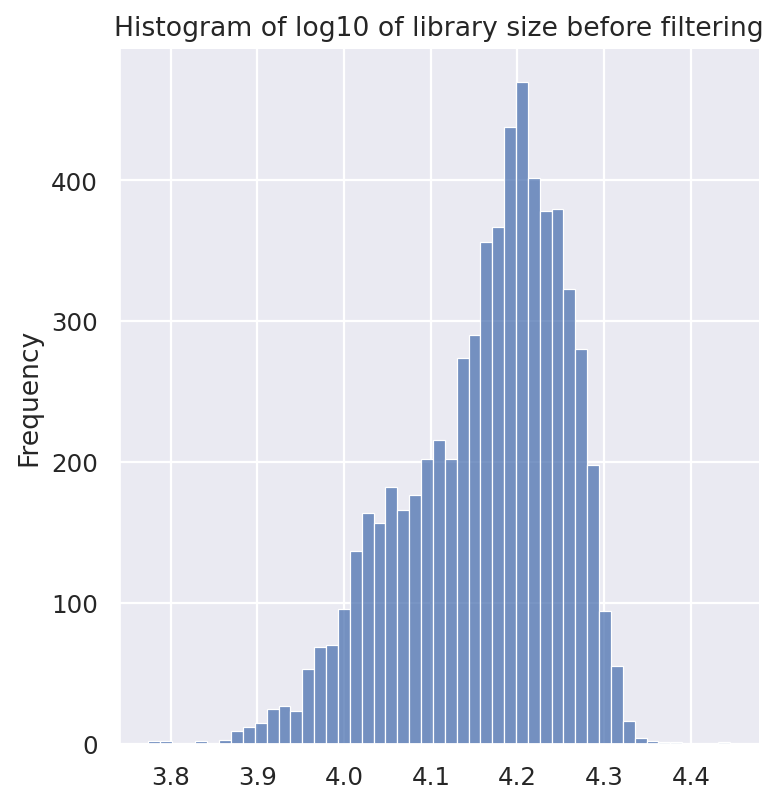

In [6]:
sc.settings.set_figure_params(dpi=80)
sns.set(color_codes=True)

plt.figure(figsize=(8, 8))
sns.displot(np.log10(ls))
plt.title('Histogram of log10 of library size before filtering')
plt.ylabel('Frequency')

## Number of cells per gene

In [7]:
num_cells = np.sum(raw>0, axis=1)

# Add 1 to those genes that are expressed in 0 cells for log calculation
num_cells[num_cells==0] = 1  
num_cells.shape

(23686,)

Text(-1.6694444444444532, 0.5, 'Density')

<Figure size 640x640 with 0 Axes>

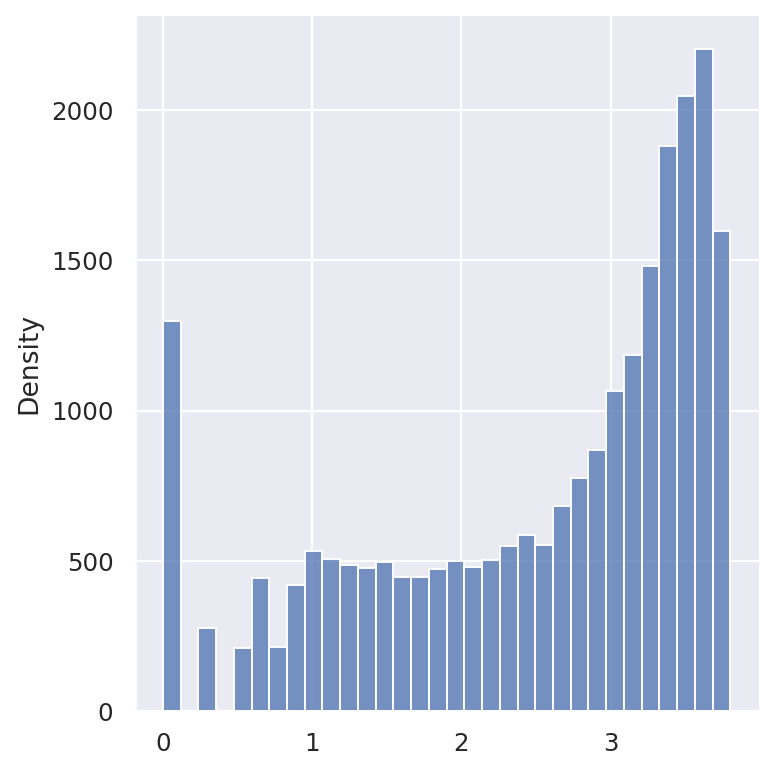

In [8]:
plt.figure(figsize=(8, 8))
sns.displot(np.log10(num_cells))
plt.ylabel('Density')

# Part 2. Normalization

In [9]:
# Convert to AnnData
adata = sc.AnnData(raw.transpose())

# # Add library size as n_counts column
# adata.obs['n_counts'] = np.nansum(raw, axis=0)

adata

AnnData object with n_obs × n_vars = 6341 × 23686

In [10]:
# adata.obs

In [11]:
threshold_cells = 3.5
threshold_genes = 2
sc.pp.filter_cells(adata, min_genes=10**threshold_cells)
sc.pp.filter_genes(adata, min_cells=10**threshold_genes)

adata

/home/myp2113/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 6096 × 16521
    obs: 'n_genes'
    var: 'n_cells'

In [12]:
# Normalization
sc.pp.normalize_total(adata)

In [13]:
# Double check the normalization result - each cell should have total counts = median_ls
adata.X.sum(axis=1)

array([15249.274, 15249.273, 15249.272, ..., 15249.271, 15249.273,
       15249.273], dtype=float32)

In [14]:
np.any(np.isnan(raw))

False

# Part 3. Dimensionality reduction

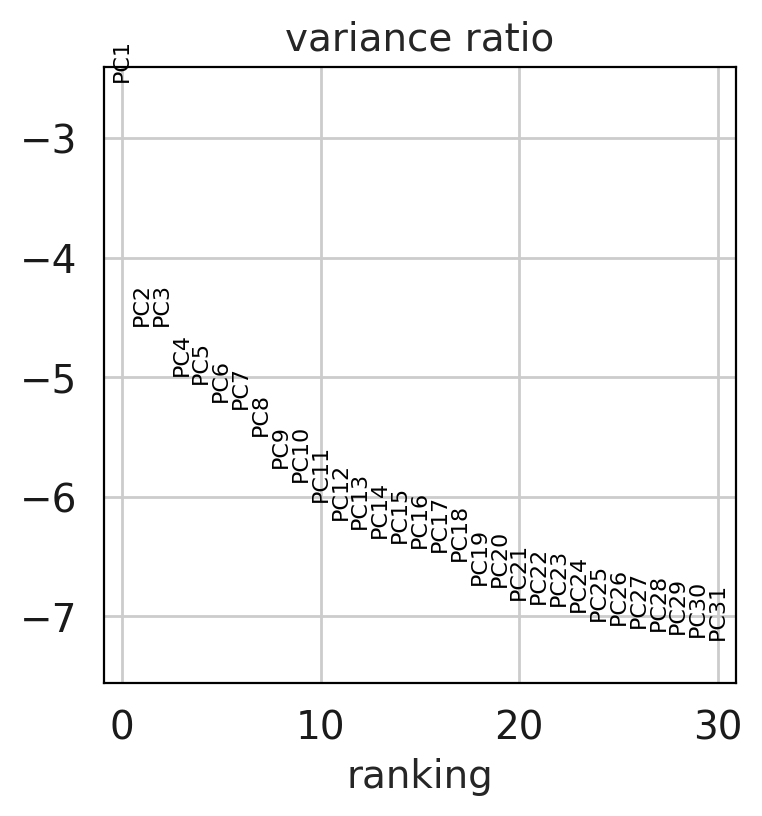

In [15]:
sc.settings.set_figure_params(dpi=100)

sc.pp.log1p(adata)
# # remove highly variable genes
# sc.pp.scale(adata, max_value=10)
# Use PCA and decide the number of principle components in Umap
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, log=True)

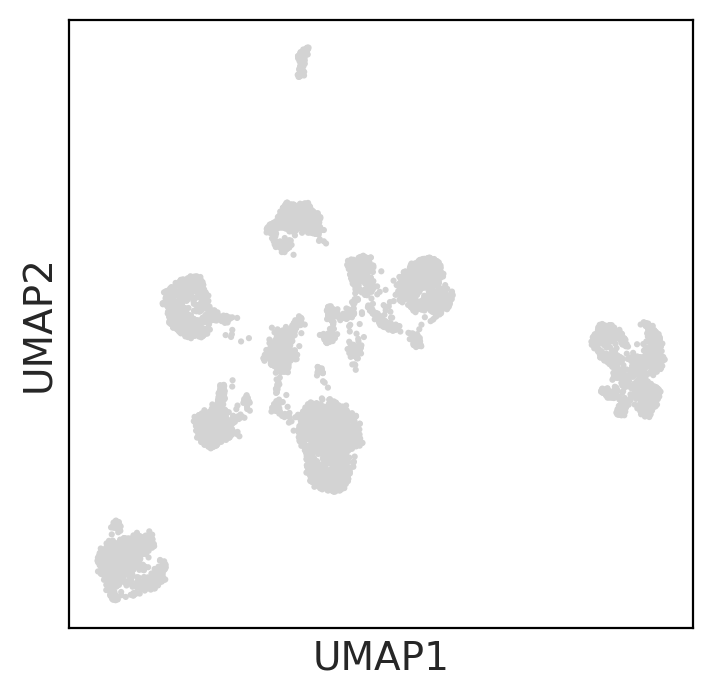

In [16]:
# Based on the figures above, choose the number of principle components

sc.pp.neighbors(adata, n_neighbors=50, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata)

# Part 4. Cluster cells based on marker genes

In [17]:
sc.tl.leiden(adata, resolution=0.5)
adata.obs

,n_genes,leiden
MGH42_P7_A01,6643,10
MGH42_P7_A02,5433,10
MGH42_P7_A03,8406,6
MGH42_P7_A04,6506,10
MGH42_P7_A05,7122,6
...,...,...
MGH107neg_P2_C05,5795,11
MGH107pos_P2_D07,3694,2
MGH107neg_P1_E01,4658,11
MGH107pos_P2_G09,3901,2


In [18]:
adata.obs.leiden

MGH42_P7_A01        10
MGH42_P7_A02        10
MGH42_P7_A03         6
MGH42_P7_A04        10
MGH42_P7_A05         6
                    ..
MGH107neg_P2_C05    11
MGH107pos_P2_D07     2
MGH107neg_P1_E01    11
MGH107pos_P2_G09     2
MGH107neg_P1_D06    11
Name: leiden, Length: 6096, dtype: category
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']

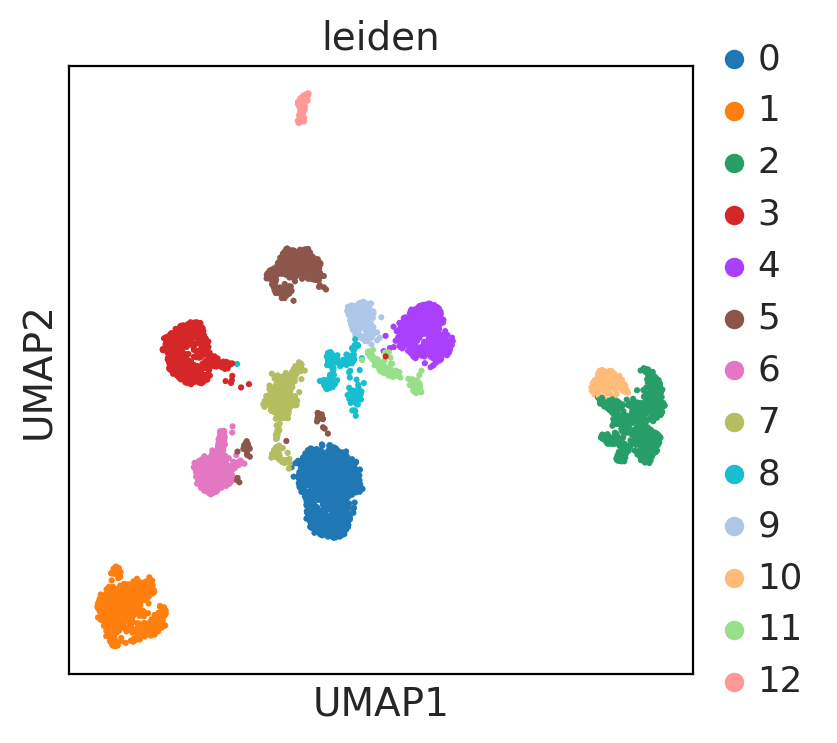

In [19]:
sc.pl.umap(adata, color='leiden')

In [20]:
# start = adata.obs.index.str.find('_') + 1
# adata.obs['batch'] = [s[i:(i+3)].replace('_', '') for s, i in zip(adata.obs.index, start)]
adata.obs['batch'] = adata.obs.index.str[0:6]
adata.obs

,n_genes,leiden,batch
MGH42_P7_A01,6643,10,P7
MGH42_P7_A02,5433,10,P7
MGH42_P7_A03,8406,6,P7
MGH42_P7_A04,6506,10,P7
MGH42_P7_A05,7122,6,P7
...,...,...,...
MGH107neg_P2_C05,5795,11,P2
MGH107pos_P2_D07,3694,2,P2
MGH107neg_P1_E01,4658,11,P1
MGH107pos_P2_G09,3901,2,P2


In [22]:
adata.obs.batch.unique()

array(['P7', 'P8', 'P3', 'P12', 'P13', 'P14', 'P15', 'P10', 'P11', 'P9',
       'P16', 'P17', 'P4', 'P5', 'P6', 'P2', 'P1', 'P20', 'MGH'],
      dtype=object)

/home/myp2113/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'batch' as categorical


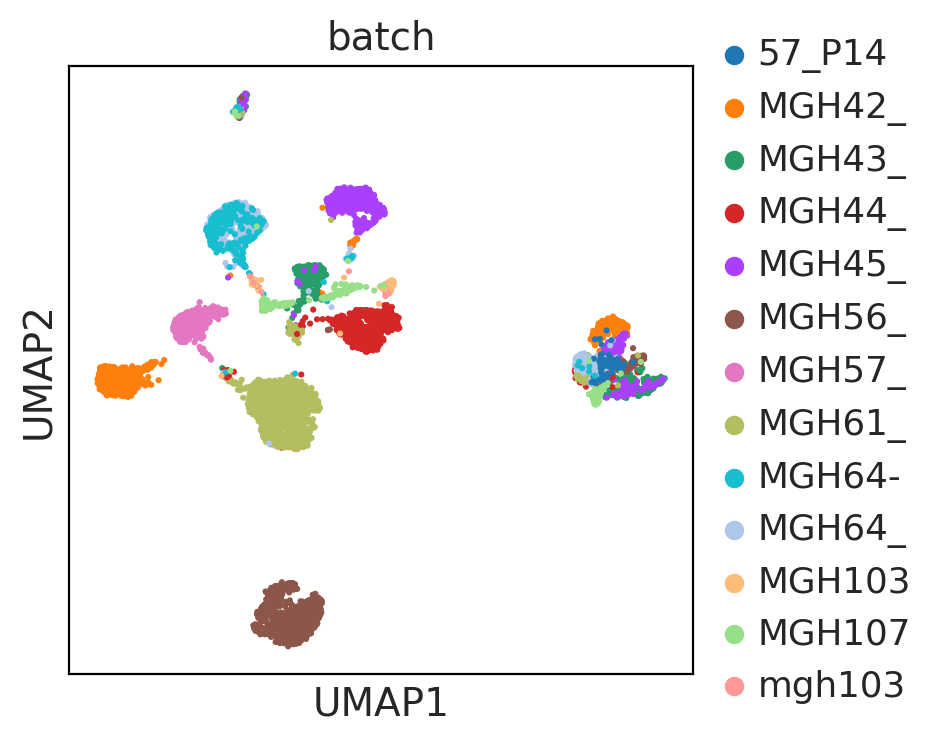

In [24]:
sc.pl.umap(adata, color='batch')

/home/myp2113/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


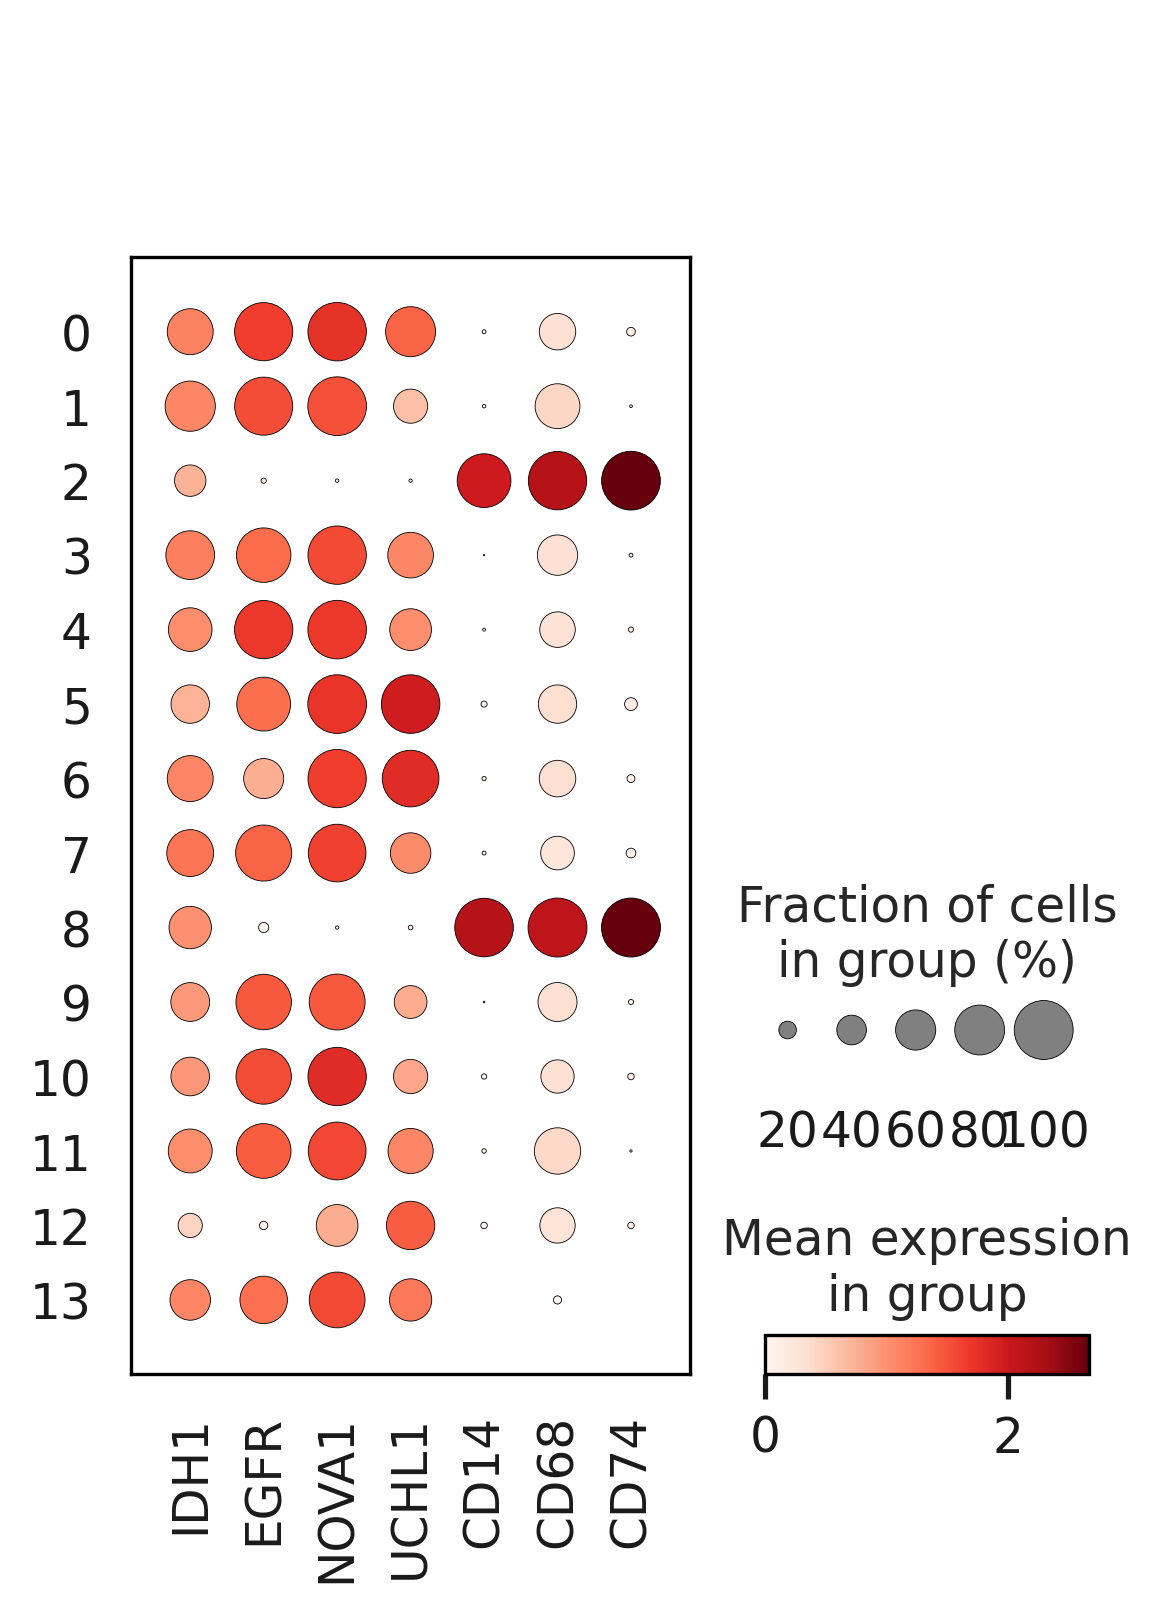

In [25]:
# Decide what marker genes to be marked for each cluster
sc.settings.set_figure_params(dpi=150)
marker_genes = ["IDH1",
                "EGFR",
                "NOVA1",  # tumor cell markers
                "UCHL1",
                "CD14",   # macrophage markers
                "CD68",
                "CD74",
#                 "'VWF'",    # endothelial markers
                # "'CLDN5'"
                ]

sc.pl.dotplot(adata, marker_genes, groupby='leiden')

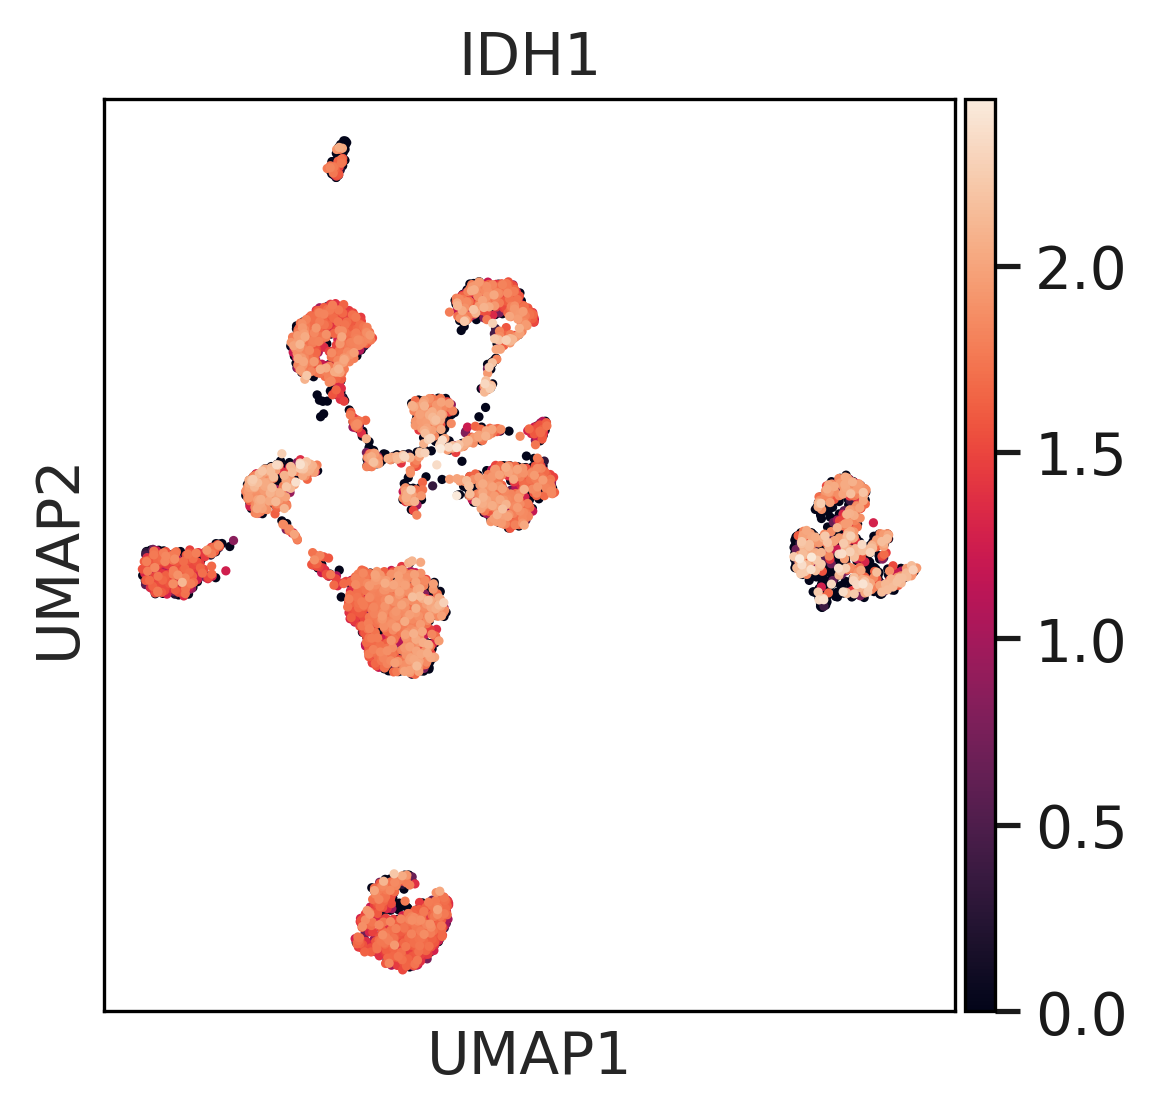

In [26]:
sc.pl.umap(adata, color=["IDH1"])

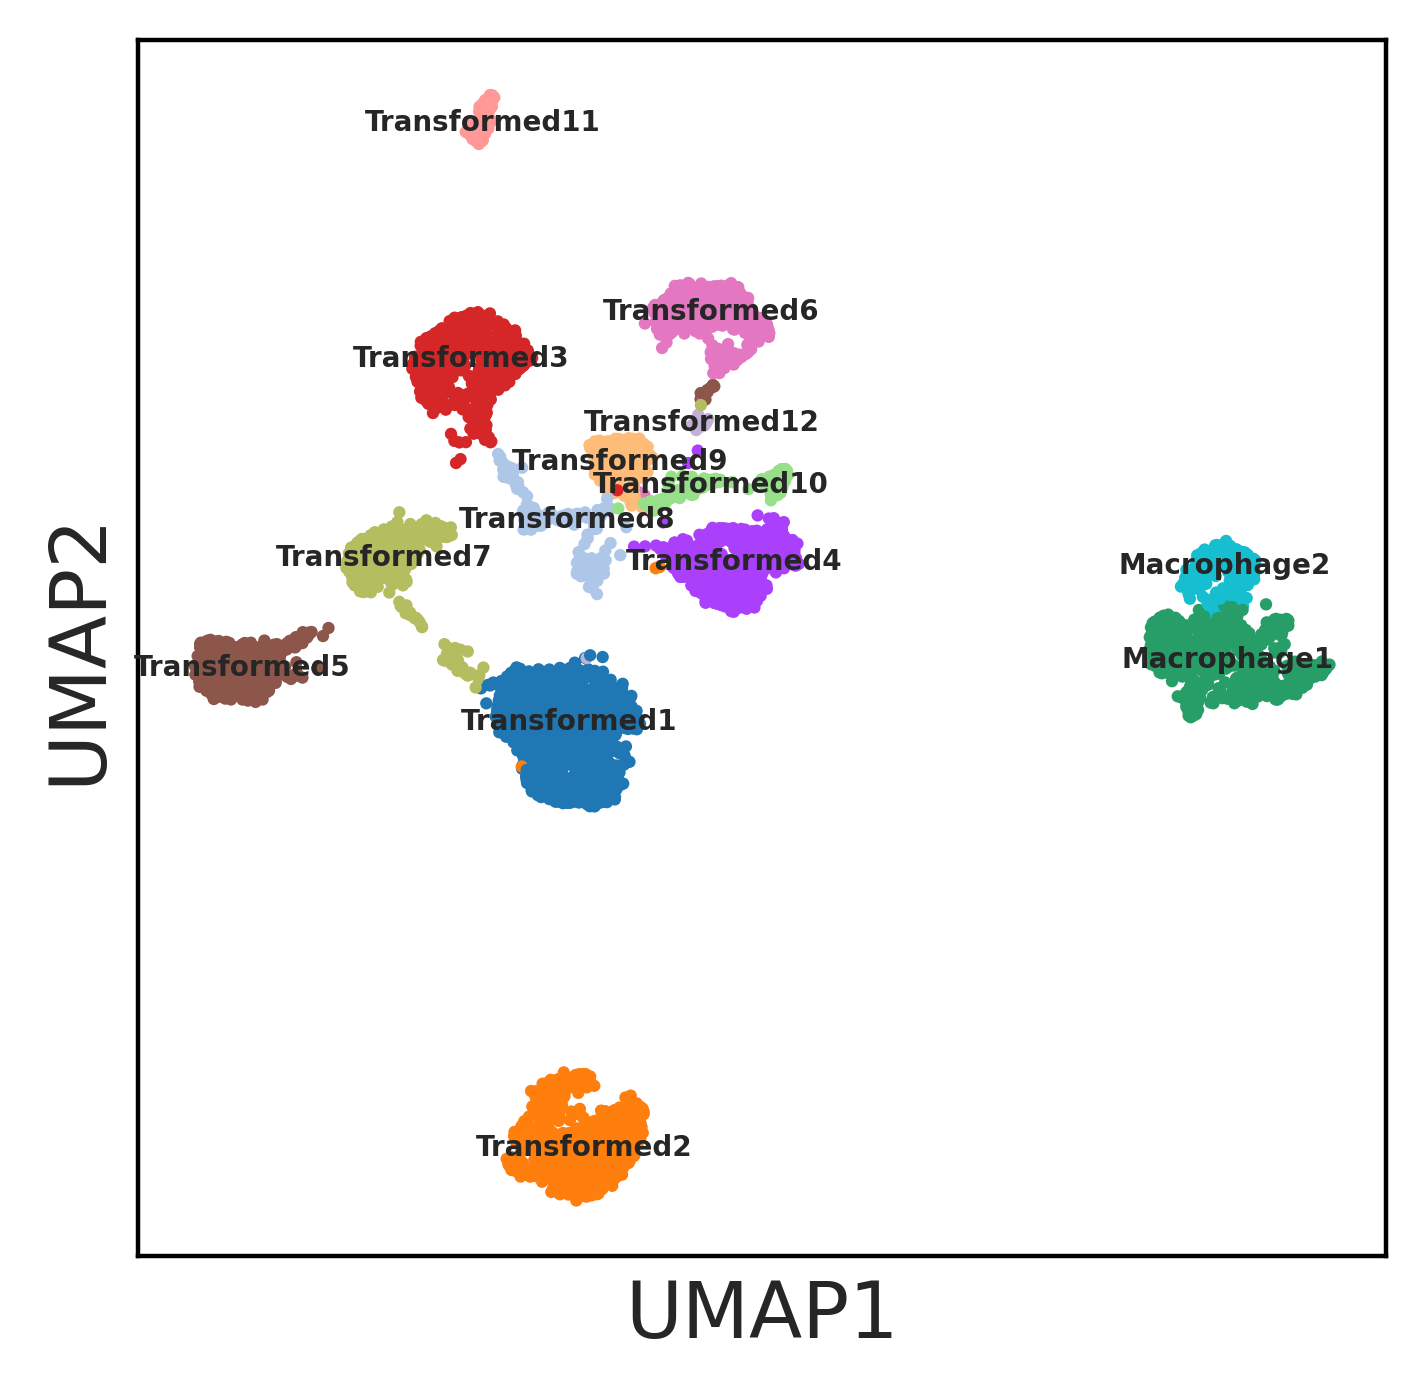

In [27]:
cluster_names = [
                 'Transformed1', #0
                 'Transformed2', #1
                 'Macrophage1', #2
                 'Transformed3', #3
                 'Transformed4', #4
                 'Transformed5', #5
                 'Transformed6', #6
                 'Transformed7', #7
                 'Macrophage2', #8
                 'Transformed8', #9
                 'Transformed9', #10
                 'Transformed10', #11
                 'Transformed11', #12
                 'Transformed12', #13
                ]

adata.rename_categories('leiden', cluster_names)

sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color='leiden', legend_loc='on data', 
           title='', legend_fontsize=5)

In [28]:
# annotation = adata.obs.leiden
# annotation

In [29]:
# # Get the original counts instead of the ones calculated by PCA and UMAP
# adata = sc.AnnData(raw_imp.transpose())
# # Add library size as n_counts column
# adata.obs['n_counts'] = np.sum(raw_imp, axis=0)

# sc.pp.filter_cells(adata, min_genes=200)
# # Filter out genes that are expressed in very few cells and are likely to be noisy genes
# sc.pp.filter_genes(adata, min_cells=10**threshold_genes)

# sc.pp.normalize_per_cell(adata)
# adata.X

In [30]:
# adata.obs['annotation'] = annotation
# adata.obs

In [31]:
# mtx = pd.DataFrame(adata.X.transpose(), 
#                               index=adata.var.index, 
#                               columns=adata.obs.index)
# mtx

In [32]:
# mtx.to_csv(DATA/"liver_mouse_healthy_mtx_normalization.csv")

In [33]:
# adata.obs.to_csv(DATA/"liver_mouse_healthy_ann_normalization.csv")